In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report,roc_auc_score
import pickle


In [3]:
# Encoding the caregorical features
data = pd.read_csv("C:\\Users\\user\\desktop\\projects\\Employee_Churn_prediction\\data\\prepared_df.csv")
df_enc = data.copy()

# Encoding the ordinal salary column

# Encode the `salary` column as an ordinal numeric category
df_enc['salary'] = (
    df_enc['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)


In [4]:
# Encoding the department column

df_enc = pd.get_dummies(df_enc,drop_first=False)

df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [5]:
percentile_25 = df_enc['tenure'].quantile(0.25)
percentile_75 = df_enc['tenure'].quantile(0.75)

iqr = percentile_75 - percentile_25

upper = (percentile_75 + 1.5) * iqr
lower = (percentile_25 - 1.5) * iqr

print(upper)
print(lower)

5.5
1.5


In [6]:
df_lr = df_enc[(df_enc['tenure'] >= lower) & (df_enc['tenure'] <= upper)]

In [7]:
df_lr.shape

(11167, 19)

In [8]:
# Separating the target and independent variables

X = df_lr.drop('left',axis=1)
y = df_lr['left']

In [9]:
# splitting into train and test sets

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0,stratify=y)

In [10]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8375, 18)
(2792, 18)
(8375,)
(2792,)


# Logistic Regression Model

In [11]:
# instantiating and fitting the model

lr = LogisticRegression(max_iter=500,random_state=0).fit(X_train,y_train)

In [12]:
y_pred_lr = lr.predict(X_test)

In [13]:
print(f" Accuracy : {accuracy_score(y_test,y_pred_lr)}")
print(f" Precision : {precision_score(y_test,y_pred_lr)}")
print(f" Recall : {recall_score(y_test,y_pred_lr)}")
print(f" f1 : {f1_score(y_test,y_pred_lr)}")

 Accuracy : 0.8262893982808023
 Precision : 0.47058823529411764
 Recall : 0.23779193205944799
 f1 : 0.31593794076163606


# Saving the models

In [67]:
path = "C:\\Users\\user\\desktop\\projects\\Employee_Churn_prediction\\models"

In [75]:
def write_pickle(path, model_object, save_as:str):
    '''
    In: 
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''    

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

In [76]:
def read_pickle(path, saved_model_name:str):
    '''
    In: 
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out: 
        model: the pickled model 
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

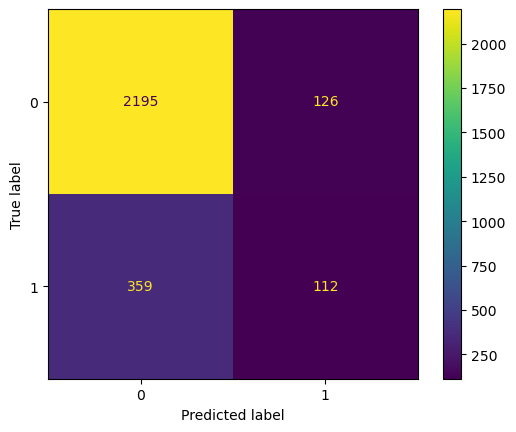

In [17]:
# Create a confusion matrix

conf_mat = confusion_matrix(y_test,y_pred_lr)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=lr.classes_)
disp.plot(values_format='')
plt.show()

In [20]:
df_lr['left'].value_counts(normalize=True)

left
0    0.831468
1    0.168532
Name: proportion, dtype: float64

In [22]:
# Create classification report for logistic regression model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred_lr, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.95      0.90      2321
    Predicted would leave       0.47      0.24      0.32       471

                 accuracy                           0.83      2792
                macro avg       0.67      0.59      0.61      2792
             weighted avg       0.79      0.83      0.80      2792



# SGD Classifier

In [23]:
# Isolate the outcome variable
y = df_enc['left']

# Display the first few rows of `y`
y.head()

0    1
1    1
2    1
3    1
4    1
Name: left, dtype: int64

In [24]:
# Select the features
X = df_enc.drop('left', axis=1)

# Display the first few rows of `X`
X.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,0,0,False,False,False,False,False,False,False,True,False,False


In [25]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=0)

In [26]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(8993, 18)
(2998, 18)
(8993,)
(2998,)


In [27]:
# Modelling using the SGD Classifier due to the class imbalance

class_weights = {0: 1.0, 1: 5.0}

# Instantiate the model
model = SGDClassifier(loss='log_loss', class_weight=class_weights,random_state=42)

In [28]:
sgd = model.fit(X_train,y_train)
y_pred_sgd = sgd.predict(X_test)

In [29]:
print(f" Accuracy : {accuracy_score(y_test,y_pred_sgd)}")
print(f" Precision : {precision_score(y_test,y_pred_sgd)}")
print(f" Recall : {recall_score(y_test,y_pred_sgd)}")
print(f" f1 : {f1_score(y_test,y_pred_sgd)}")

 Accuracy : 0.7975316877918612
 Precision : 0.3857442348008386
 Recall : 0.36947791164658633
 f1 : 0.37743589743589745


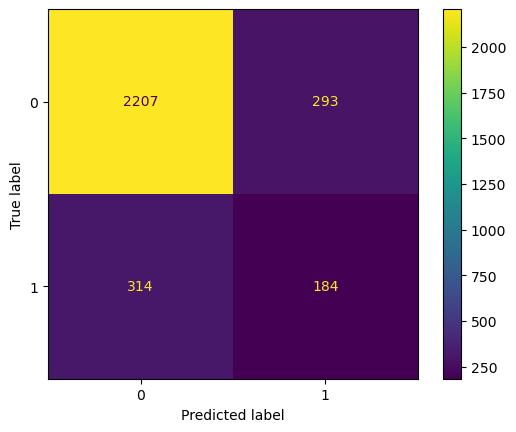

In [30]:
conf_mat = confusion_matrix(y_test,y_pred_sgd)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=sgd.classes_)
disp.plot(values_format='')
plt.show()

In [31]:
# Create classification report for sgd model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred_sgd, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.88      0.88      0.88      2500
    Predicted would leave       0.39      0.37      0.38       498

                 accuracy                           0.80      2998
                macro avg       0.63      0.63      0.63      2998
             weighted avg       0.79      0.80      0.80      2998



The classification report above shows that the logistic regression model achieved a precision of 86%, recall of 94%, f1-score of 90% (all weighted averages), and accuracy of 79%. However, if it's most important to predict employees who leave, then the scores are significantly lower.

# Random Forest Model

In [35]:
rf = RandomForestClassifier(random_state=0)

rf_params = {'min_samples_split':[1,2],
            'min_samples_leaf':[2,3],
            'n_estimators':[300,500],
            'max_features':["sqrt"],
            'max_samples':[0.5,0.9]
            }

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

model1 = GridSearchCV(rf, rf_params, scoring=scoring, cv=5, refit='f1') 

In [36]:
%%time
model1.fit(X_train,y_train)

c:\Users\user\anaconda3\envs\employee_churn\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\anaconda3\envs\employee_churn\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\anaconda3\envs\employee_churn\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\user\anaconda3\envs\employee_churn\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validat

CPU times: total: 1min 13s
Wall time: 1min 14s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_features': ['sqrt'], 'max_samples': [0.5, 0.9],
                         'min_samples_leaf': [2, 3],
                         'min_samples_split': [1, 2],
                         'n_estimators': [300, 500]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

# Saving the model

In [72]:
# Write pickle
write_pickle(path, model1, 'Random_Forest_1')

In [73]:
# Read pickle
rf1 = read_pickle(path, 'Random_Forest_1')

In [74]:
rf1.best_score_

0.9451941741119475

In [77]:
rf1.best_params_

{'max_features': 'sqrt',
 'max_samples': 0.9,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 500}

In [40]:
def make_results(model_name:str, model_object, metric:str):

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })
  
    return table

In [41]:
results1 = make_results('Random Forest',model1,'f1')
results1

,model,precision,recall,F1,accuracy,auc
0,Random Forest,0.986148,0.907564,0.945194,0.982542,0.980765


In [44]:
def get_scores(model_name:str, model, X_test_data, y_test_data):

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision], 
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })
  
    return table

In [45]:
test_score1 = get_scores('Random Forest Test',model1,X_test,y_test)
test_score1

,model,precision,recall,f1,accuracy,AUC
0,Random Forest Test,0.989059,0.907631,0.946597,0.982989,0.952815


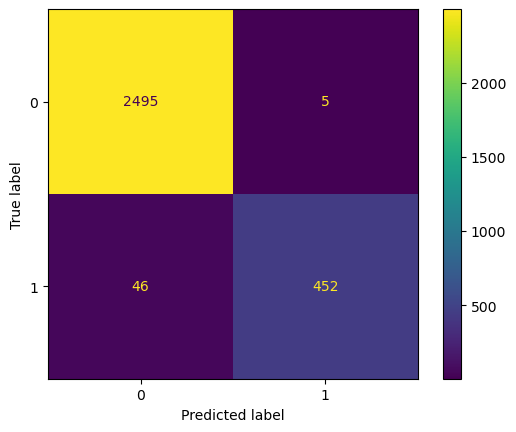

In [46]:
# Plotting a confusion matrix

y_pred_rf = model1.predict(X_test)

conf_mat = confusion_matrix(y_test,y_pred_rf)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=model.classes_)
disp.plot(values_format='')
plt.show()

In [47]:
# Classification Report

target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred_rf, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.98      1.00      0.99      2500
    Predicted would leave       0.99      0.91      0.95       498

                 accuracy                           0.98      2998
                macro avg       0.99      0.95      0.97      2998
             weighted avg       0.98      0.98      0.98      2998



## Feature Engineering

In [48]:
df2 = df_enc.drop('satisfaction_level',axis=1)
df2.head()

,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [49]:
print(f' Minimum monthly hours: {df2["average_monthly_hours"].min()}')
print(f' Maximum monthly hours: {df2["average_monthly_hours"].max()}')

 Minimum monthly hours: 96
 Maximum monthly hours: 310


In [50]:
# create an overworked column

df2['overworked'] = df2['average_monthly_hours']
df2['overworked'] = (df2['overworked'] > 175).astype(int)

In [51]:
df2.head()

,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,overworked
0,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0
1,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
2,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False,1
3,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False,1
4,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False,0


In [52]:
X = df2.drop('left',axis=1)
y = df2['left']

In [53]:
# Splitting the dataframe again

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,stratify=y,random_state=42)

In [54]:
rf = RandomForestClassifier(random_state=0)

rf_params = {'min_samples_split':[1,2],
            'min_samples_leaf':[2,3],
            'n_estimators':[300,500],
            'max_features':["sqrt"],
            'max_samples':[0.5,0.9]
            }

scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc': 'roc_auc'
}

model2 = GridSearchCV(rf, rf_params, scoring=scoring, cv=5, refit='f1')

In [55]:
%%time
model2.fit(X_train,y_train)

c:\Users\user\anaconda3\envs\employee_churn\Lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
40 fits failed out of a total of 80.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user\anaconda3\envs\employee_churn\Lib\site-packages\sklearn\model_selection\_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user\anaconda3\envs\employee_churn\Lib\site-packages\sklearn\base.py", line 1144, in wrapper
    estimator._validate_params()
  File "c:\Users\user\anaconda3\envs\employee_churn\Lib\site-packages\sklearn\base.py", line 637, in _validate_params
    validat

CPU times: total: 1min 7s
Wall time: 1min 8s


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_features': ['sqrt'], 'max_samples': [0.5, 0.9],
                         'min_samples_leaf': [2, 3],
                         'min_samples_split': [1, 2],
                         'n_estimators': [300, 500]},
             refit='f1',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [78]:
# Write pickle
write_pickle(path, model2, 'Random_Forest_2')

In [79]:
# Read pickle
rf2 = read_pickle(path, 'Random_Forest_2')

In [80]:
rf2.best_score_

0.9159340029949616

In [81]:
rf2.best_params_

{'max_features': 'sqrt',
 'max_samples': 0.9,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 300}

In [58]:
# Grabbing the cv results
rf2_results = make_results('Random Forest 2', model2, 'f1')
rf2_results

,model,precision,recall,F1,accuracy,auc
0,Random Forest 2,0.942551,0.890824,0.915934,0.972868,0.974776


In [59]:
# Grabbing the test results
rf2_test_scores = get_scores('Random Forest 2 Test', model2, X_test, y_test)
rf2_test_scores

,model,precision,recall,f1,accuracy,AUC
0,Random Forest 2 Test,0.952891,0.893574,0.92228,0.974983,0.942387


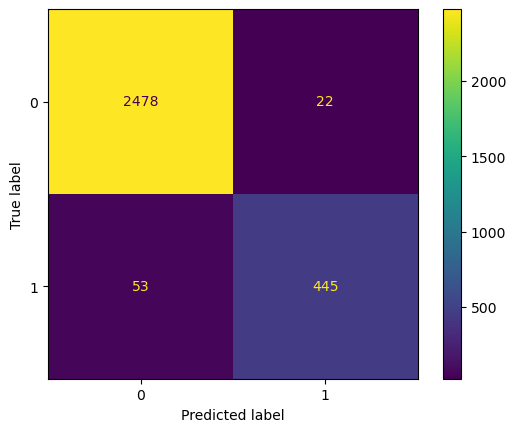

In [60]:
# Confusion matrix
y_pred_rf2 = model2.predict(X_test)

conf_mat = confusion_matrix(y_test,y_pred_rf2)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat,display_labels=model2.classes_)
disp.plot(values_format='')
plt.show()

In [61]:
# Classification Report

target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred_rf2, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.98      0.99      0.99      2500
    Predicted would leave       0.95      0.89      0.92       498

                 accuracy                           0.97      2998
                macro avg       0.97      0.94      0.95      2998
             weighted avg       0.97      0.97      0.97      2998



In [62]:
# feature importances

importances = model1.best_estimator_.feature_importances_
rf_importances = pd.Series(importances,index=X_test.columns)

Text(0.5, 1.0, 'Feature Importances')

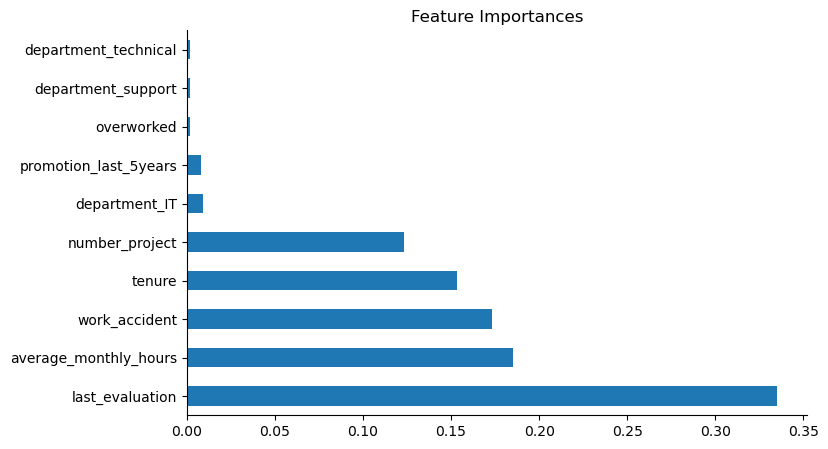

In [90]:
rf_importances.sort_values(ascending=False).head(10).plot(kind='barh',figsize=(8,5))
plt.savefig("Importaces.png")
sns.despine()
plt.title('Feature Importances')

In [64]:
df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


## Findings and Recommendations

The models and the feature importances extracted from the models confirm that employees at the company are overworked.

To retain employees, the following recommendations could be presented to the stakeholders:

- Cap the number of projects that employees can work on.
- Consider promoting employees who have been with the company for atleast four years, or conduct further investigation about why four-year tenured employees are so dissatisfied.
- Either reward employees for working longer hours, or don't require them to do so.
- If employees aren't familiar with the company's overtime pay policies, inform them about this. If the expectations around workload and time off aren't explicit, make them clear.
- Hold company-wide and within-team discussions to understand and address the company work culture, across the board and in specific contexts.
- High evaluation scores should not be reserved for employees who work 200+ hours per month. Consider a proportionate scale for rewarding employees who contribute more/put in more effort.